In [1]:
pip install langdetect


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install contractions


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()


C:\Users\himan\AppData\Local\Temp\ipykernel_8072\2622219498.py:59: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [4]:
df = pd.read_csv("cyberbullying_tweets.csv")


In [5]:
df.head()


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
df.shape

(47692, 2)

In [8]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})


In [11]:
df

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [12]:
df.duplicated().sum()


36

In [13]:
df = df[~df.duplicated()]


In [14]:
df

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [15]:
df.sentiment.value_counts()


sentiment
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [16]:
import re

def strip_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [17]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]


C:\Users\himan\AppData\Local\Temp\ipykernel_8072\2818814255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]


In [18]:
df

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black people expected anything depended anythi...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold disappointment turner called c...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt nigger fucking unfollow fucking du...


In [19]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6253 duplicated tweets, we will remove them.


In [20]:
df.drop_duplicates("text_clean", inplace=True)


C:\Users\himan\AppData\Local\Temp\ipykernel_8072\2567611958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates("text_clean", inplace=True)


In [21]:
df.sentiment.value_counts()


sentiment
religion               7917
age                    7816
ethnicity              7401
gender                 7284
not_cyberbullying      6076
other_cyberbullying    4909
Name: count, dtype: int64

In [22]:
df = df[df["sentiment"]!="other_cyberbullying"]


In [23]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]


In [24]:
df['text_len'] = [len(text.split()) for text in df.text_clean]


C:\Users\himan\AppData\Local\Temp\ipykernel_8072\1353625871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = [len(text.split()) for text in df.text_clean]


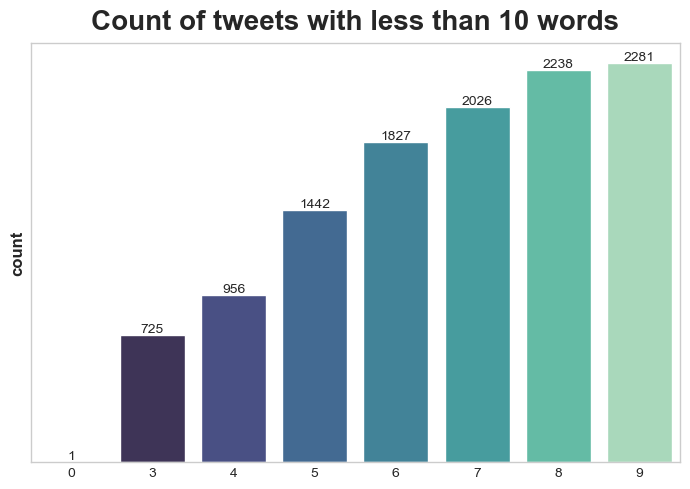

In [25]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [26]:
df.sort_values(by=['text_len'], ascending=False)


,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
5933,@Erwin_Dawson Islam's idea of coexistence. htt...,not_cyberbullying,islam idea coexistence,3
5913,The puppy I almost got: https://t.co/uG9ruAz6BA,not_cyberbullying,puppy almost got,3
5903,@apache6645 thursday n friday confirmed,not_cyberbullying,thursday friday confirmed,3
31820,"Ah, so you were the school bully?",age,ah school bully,3


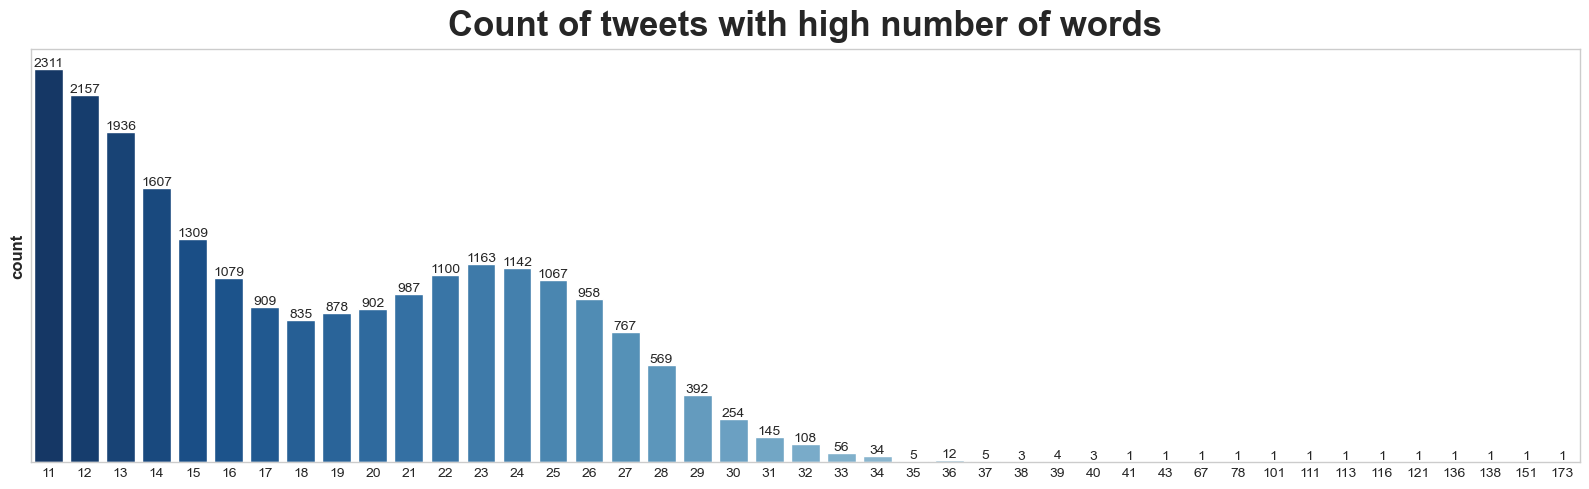

In [27]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [28]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]


In [29]:
df

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black people expected anything depended anythi...,21
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold disappointment turner called c...,29
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt nigger fucking unfollow fucking du...,9


In [30]:
max_len = np.max(df['text_len'])
max_len 

31

In [31]:
df.sort_values(by=["text_len"], ascending=False)


,text,sentiment,text_clean,text_len
20828,#ISIS #OsamabinLaden #Hizbul &amp;all #terrori...,religion,isi osamabinladen hizbul ampall terrorist read...,31
21541,"Pagan woman: matted hair, dirty face, titties ...",religion,pagan woman matted hair dirty face titty waili...,31
22885,A bunch of idiots walking around claiming sala...,religion,bunch idiot walking around claiming salaf quot...,31
12892,The best millennials could pick for humor in t...,gender,best millennials could pick humor early joke p...,31
19663,Can't stand social media sometimes cos of the ...,religion,can not stand social medium sometimes co insen...,31
...,...,...,...,...
38165,//MILFS at the end of the video.,age,milfs end video,3
46946,oh ur the first one there,ethnicity,oh first one,3
5445,Finally a break from school !!!,not_cyberbullying,finally break school,3
4558,Bully beatdown how bout that,not_cyberbullying,bully beatdown bout,3


In [32]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [33]:
X = df['text_clean']
y = df['sentiment']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [35]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6270],
       [   1, 6209],
       [   2, 5874],
       [   3, 5789],
       [   4, 4858]], dtype=int64)

In [36]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [37]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [38]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6270],
       [   1, 6270],
       [   2, 6270],
       [   3, 6270],
       [   4, 6270]], dtype=int64)

In [39]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [40]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [41]:
nb_clf = MultinomialNB()


In [42]:
nb_clf.fit(X_train_tf, y_train)


MultinomialNB()

In [43]:
nb_pred = nb_clf.predict(X_test_tf)


In [44]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.86      0.97      0.91      1568
         age       0.81      0.98      0.89      1553
   ethnicity       0.89      0.92      0.90      1468
      gender       0.88      0.84      0.86      1447
not bullying       0.80      0.48      0.60      1215

    accuracy                           0.85      7251
   macro avg       0.85      0.84      0.83      7251
weighted avg       0.85      0.85      0.84      7251



In [45]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [46]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)


In [47]:
vocabulary

[('school', 8861),
 ('fuck', 5349),
 ('girl', 5345),
 ('like', 5273),
 ('nigger', 5053),
 ('joke', 5037),
 ('high', 4927),
 ('people', 4902),
 ('dumb', 4763),
 ('muslim', 4678),
 ('bully', 4485),
 ('bullied', 4374),
 ('gay', 4061),
 ('rape', 3968),
 ('one', 3379),
 ('rt', 3191),
 ('idiot', 3150),
 ('woman', 2951),
 ('black', 2752),
 ('would', 2665),
 ('get', 2642),
 ('as', 2422),
 ('know', 2321),
 ('bitch', 2295),
 ('amp', 2249),
 ('white', 2172),
 ('christian', 2103),
 ('right', 2084),
 ('mkr', 2070),
 ('say', 2017),
 ('think', 1998),
 ('make', 1950),
 ('call', 1768),
 ('want', 1718),
 ('go', 1616),
 ('got', 1586),
 ('can', 1571),
 ('not', 1569),
 ('time', 1510),
 ('even', 1464),
 ('called', 1394),
 ('terrorist', 1392),
 ('shit', 1364),
 ('see', 1357),
 ('never', 1349),
 ('year', 1300),
 ('really', 1271),
 ('islam', 1266),
 ('going', 1266),
 ('thing', 1266),
 ('support', 1260),
 ('first', 1247),
 ('still', 1240),
 ('islamic', 1233),
 ('fucking', 1223),
 ('said', 1194),
 ('female', 116

In [48]:
tokenized_column

array([[    0,     0,     0, ...,   563, 15535,    29],
       [    0,     0,     0, ...,  7693, 15538,   194],
       [    0,     0,     0, ...,   648,  9016,  5062],
       ...,
       [    0,     0,     0, ...,   431, 37580,     2],
       [    0,     0,     0, ...,    55,     9,     5],
       [    0,     0,     0, ...,     5,    24,   189]])

In [49]:
df["text_clean"].iloc[0]


'word katandandre food crapilicious mkr'

In [50]:
tokenized_column[10]


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    11,  7694, 15539])

In [51]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

In [52]:
keys

['school',
 'fuck',
 'girl',
 'like',
 'nigger',
 'joke',
 'high',
 'people',
 'dumb',
 'muslim',
 'bully',
 'bullied',
 'gay',
 'rape',
 'one',
 'rt',
 'idiot',
 'woman',
 'black',
 'would']

In [53]:
values

[8861,
 5349,
 5345,
 5273,
 5053,
 5037,
 4927,
 4902,
 4763,
 4678,
 4485,
 4374,
 4061,
 3968,
 3379,
 3191,
 3150,
 2951,
 2752,
 2665]

C:\Users\himan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


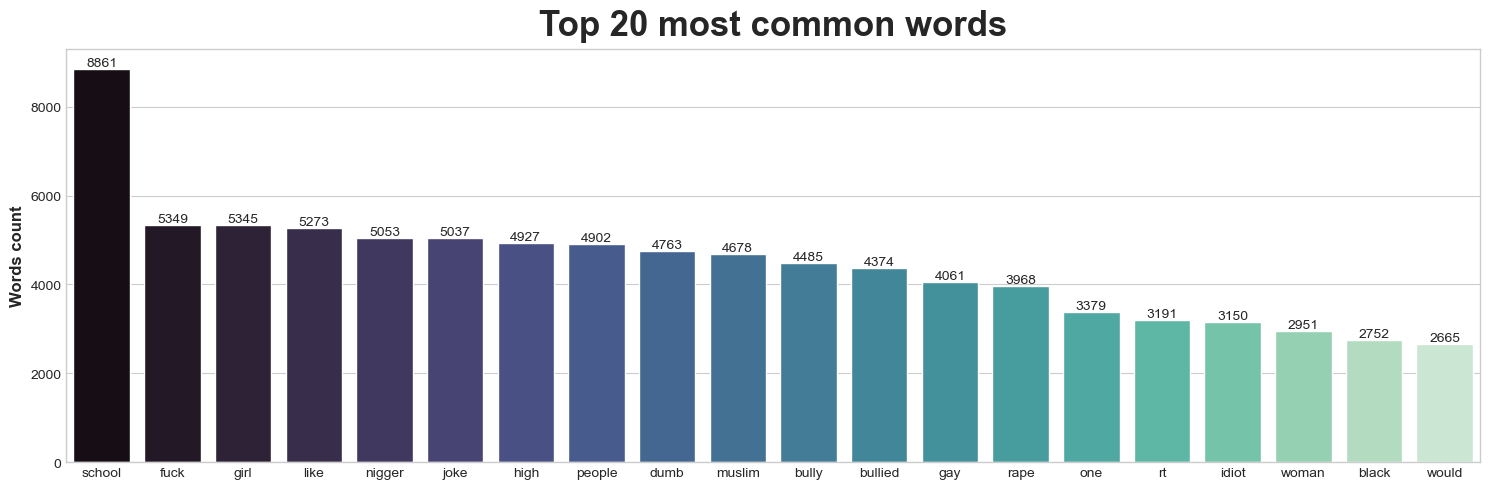

In [54]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [55]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))


In [56]:
EMBEDDING_DIM = 200


In [57]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)


In [58]:
print(f"Vocabulary size: {len(vocabulary) + 1}")


Vocabulary size: 37581


In [59]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding


In [60]:
VOCAB_SIZE

37581

In [61]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37581, 200)


In [62]:
X = tokenized_column
y = df['sentiment'].values

In [63]:
X

array([[    0,     0,     0, ...,   563, 15535,    29],
       [    0,     0,     0, ...,  7693, 15538,   194],
       [    0,     0,     0, ...,   648,  9016,  5062],
       ...,
       [    0,     0,     0, ...,   431, 37580,     2],
       [    0,     0,     0, ...,    55,     9,     5],
       [    0,     0,     0, ...,     5,    24,   189]])

In [64]:
y

array([4, 4, 4, ..., 2, 2, 2], dtype=int64)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5016],
       [   1, 5016],
       [   2, 5016],
       [   3, 5016],
       [   4, 5016]], dtype=int64)

In [66]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
BATCH_SIZE = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [67]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return h0,c0

In [68]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(37581, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [69]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.092541).  Saving model ...
	Train_loss : 0.6149 Val_loss : 0.2386
	Train_acc : 76.257% Val_acc : 92.093%
Epoch 2:Validation accuracy increased (92.092541 --> 92.834945).  Saving model ...
	Train_loss : 0.1723 Val_loss : 0.2076
	Train_acc : 94.389% Val_acc : 92.835%
Epoch 3:Validation accuracy increased (92.834945 --> 93.007597).  Saving model ...
	Train_loss : 0.0964 Val_loss : 0.2234
	Train_acc : 97.015% Val_acc : 93.008%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0637 Val_loss : 0.2459
	Train_acc : 98.036% Val_acc : 92.006%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0426 Val_loss : 0.2862
	Train_acc : 98.779% Val_acc : 91.333%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0325 Val_loss : 0.2826
	Train_acc : 99.086% Val_acc : 92.023%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0222 Val_loss : 0.3633
	Train_acc : 99.385% Val_acc : 90.988%
Epoch 8:Validation accurac

In [70]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [71]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [72]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.95      0.94      0.95      1561
         age       0.98      0.97      0.97      1552
   ethnicity       0.98      0.98      0.98      1463
      gender       0.94      0.83      0.88      1445
not bullying       0.76      0.87      0.81      1211

    accuracy                           0.92      7232
   macro avg       0.92      0.92      0.92      7232
weighted avg       0.93      0.92      0.92      7232



In [73]:
X = df['text_clean'].values
y = df['sentiment'].values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [76]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [77]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [78]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5016],
       [   1, 5016],
       [   2, 5016],
       [   3, 5016],
       [   4, 5016]], dtype=int64)

In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [80]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [81]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


In [82]:
MAX_LEN = 128


In [83]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\himan\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [84]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [85]:
batch_size = 32


In [86]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [87]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [88]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [90]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)


C:\Users\himan\anaconda3\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [91]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [92]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)


Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.666363   |  1346.91 
   200    |   0.283897   |  1310.32 
   300    |   0.237906   |  1342.90 
   400    |   0.233712   |  1349.24 
   500    |   0.227957   |  1283.92 
   600    |   0.204465   |  1265.01 
   700    |   0.204783   |  1287.46 
   783    |   0.187160   |  1090.80 
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.283302    |  0.171871  |       94.45       | 11107.44 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.157547   |  1300.26 
   200    |   0.139651   |  1283.68 
   3

In [93]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [94]:
bert_preds = bert_predict(bert_classifier, test_dataloader)


In [95]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.96      0.96      1568
         age       0.99      0.97      0.98      1553
   ethnicity       0.99      0.99      0.99      1468
      gender       0.92      0.90      0.91      1447
not bullying       0.81      0.86      0.84      1215

    accuracy                           0.94      7251
   macro avg       0.93      0.94      0.93      7251
weighted avg       0.94      0.94      0.94      7251



In [102]:
cm=confusion_matrix(y_test, bert_preds)


In [103]:
cm

array([[1513,    0,    1,    4,   50],
       [   0, 1509,    1,    7,   36],
       [   4,    3, 1446,    5,   10],
       [   6,    2,    2, 1296,  141],
       [  58,    5,    9,  100, 1043]], dtype=int64)

<Axes: >

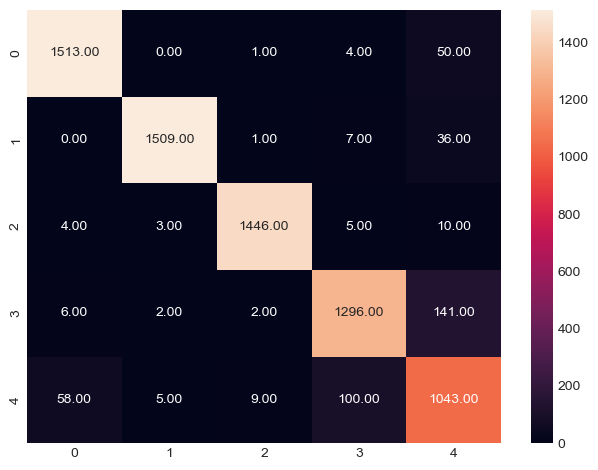

In [107]:
sns.heatmap(cm,annot=True,fmt="1.2f")